In [1]:
from __future__ import annotations

import json
import logging
import math
import os
import pickle
import shutil
from typing import TypeAlias

import igraph as ig
import matplotlib as mplt
from matplotlib import pyplot as plt
from tqdm import tqdm

log = logging.getLogger("aa72")
with open("logging.config.json", "rt") as f:
    logging.config.dictConfig(json.load(f))

Pixel: TypeAlias = tuple[int, int]
PixelList: TypeAlias = list[Pixel]

Point: TypeAlias = tuple[float, float] | Pixel
PointList: TypeAlias = list[Point] | PixelList

# Load data

In [2]:
IN_PATH = os.path.join("data", "out_01", "out.pickle")

In [3]:
contours = {}
corners = {}
with open(IN_PATH, "rb") as f:
    for piece_id, contour, piece_corners in tqdm(pickle.load(f)):
        if piece_id in (15, 1247, 1246, 16):
            contours[piece_id] = tuple(tuple(map(int, pixel)) for pixel in contour)
            corners[piece_id] = tuple(
                tuple(map(float, point)) for point in piece_corners
            )

pieces_ids = list(contours.keys())

100%|██████████| 2000/2000 [00:00<00:00, 32935.51it/s]


# Preview utils

In [4]:
plt.rcParams.update(
    {
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)


def get_figure(n_axis: int) -> tuple[mplt.figure.Figure, list[mplt.axes.Axes]]:
    """Create and return pyplot figure."""
    n_cols = 4
    n_rows = math.ceil(n_axis / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols)

    figscale = 3
    fig.set_figwidth(n_cols * figscale)
    fig.set_figheight(n_rows * figscale)
    fig.subplots_adjust(hspace=0.35)
    fig.set_dpi(300)

    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = list(axes.flat)

    return fig, axes


def scatter_plot_lines(ax: plt.Axes, title: str, lines: list[PointList]) -> None:
    """Plot multiple lines on one axis."""
    x_min = y_min = float("inf")
    x_max = y_max = -float("inf")

    for line in lines:
        if len(line) > 0:
            x = [point[0] for point in line]
            y = [point[1] for point in line]

            x_min = min(x_min, min(x))
            y_min = min(y_min, min(y))
            x_max = max(x_max, max(x))
            y_max = max(y_max, max(y))

            ax.scatter(x, y, s=1)

    size = max(x_max - x_min, y_max - y_min)

    margin = 50
    ax.set_xlim(x_min - margin, x_min + size + margin)
    ax.set_ylim(y_min - margin, y_min + size + margin)

    ax.set_title(title)
    ax.grid(True)

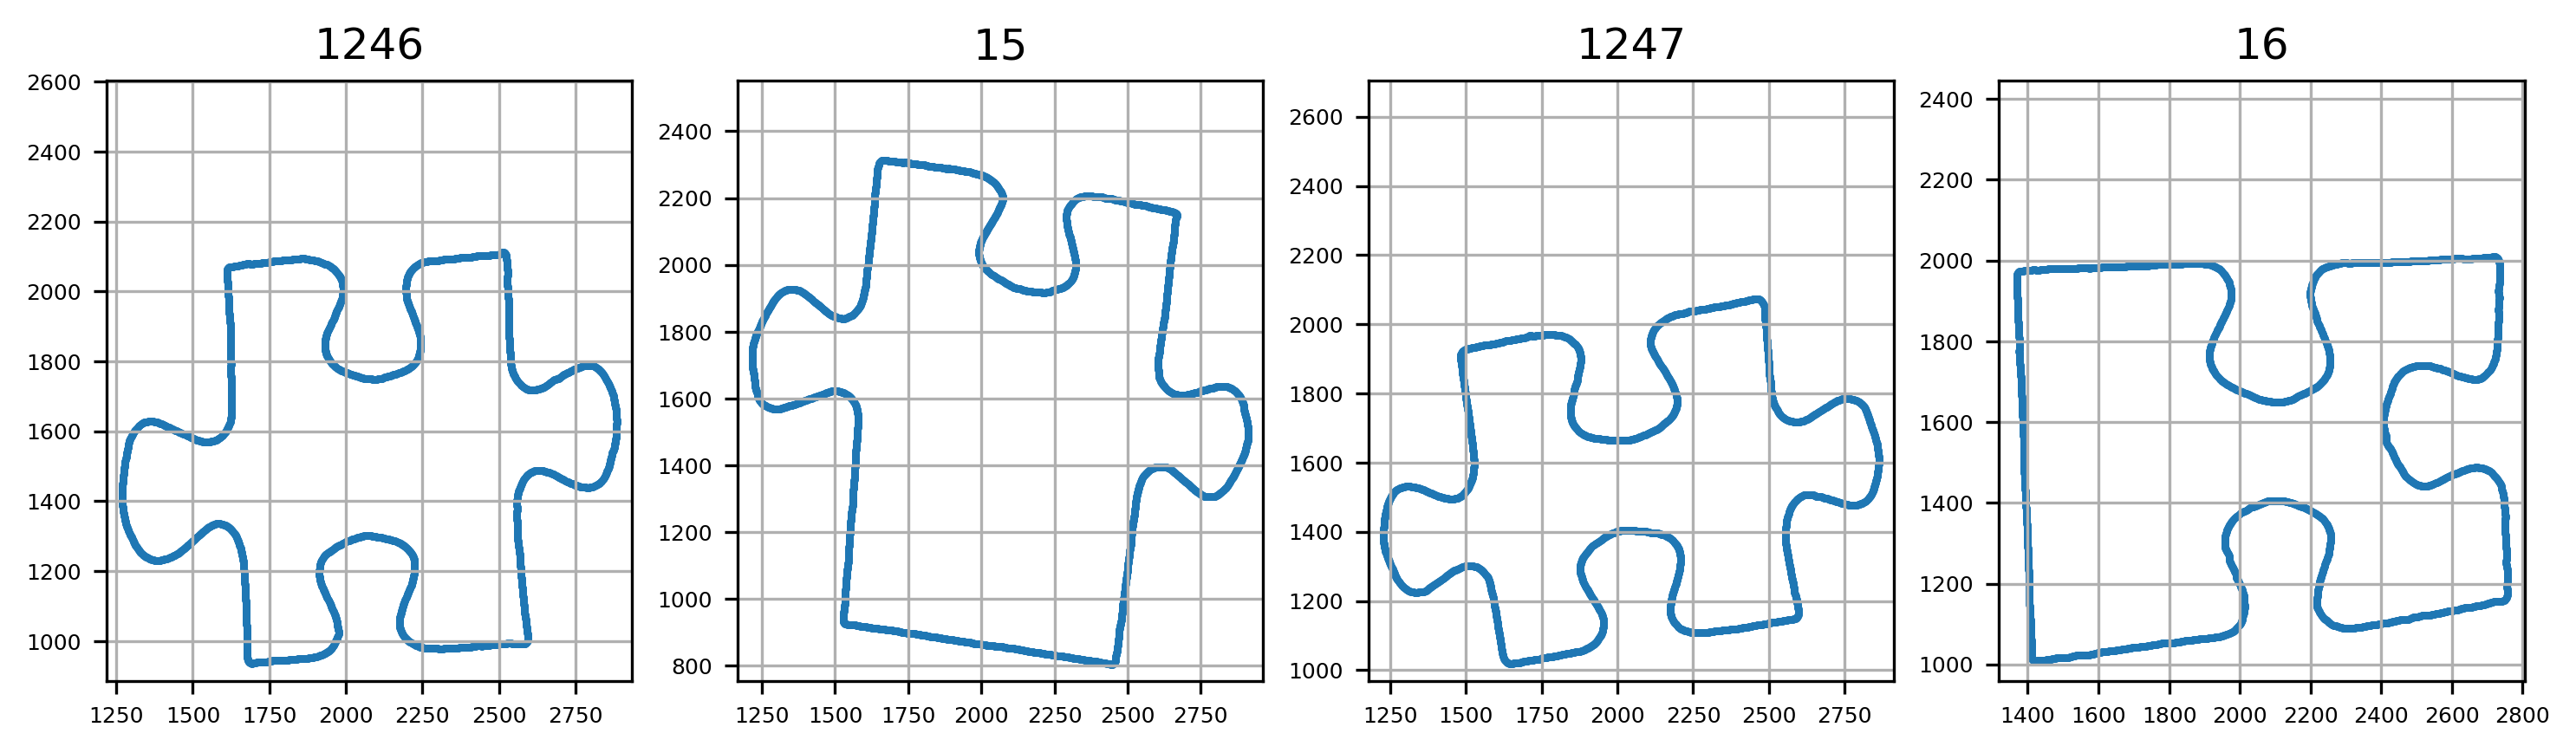

In [5]:
fig, axes = get_figure(len(pieces_ids))
for (piece_id, contour), ax in zip(contours.items(), axes):
    scatter_plot_lines(ax, piece_id, [contour])

# Split to sides

1. Build a graph from contour. Construct edges between neighboring pixels.
2. Extract sides by finding shortest path in the graph between side corners. Note that pixels in extracted sides are ordered.

In [6]:
def _distance(p1: Point, p2: Point) -> float:
    x1, y1 = p1
    x2, y2 = p2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def extract_sides(
    corners: PointList,
    contour: PixelList,
    corner_margin: float,
) -> tuple[list[PixelList], list[PointList]]:
    # Build the contour graph
    vs_id_map = {pixel: idx for idx, pixel in enumerate(contour)}
    es = []
    weights = []
    to_check = set(contour)
    while to_check:
        x, y = pixel = to_check.pop()

        for x_shift, y_shift in (
            (0, 1),  # top
            (-1, 0),  # left
            (1, 0),  # right
            (0, -1),  # bottom
            (-1, 1),  # top-left
            (1, 1),  # top-right
            (-1, -1),  # bottom-left
            (1, -1),  # bottom-right
        ):
            xn = x + x_shift
            yn = y + y_shift

            neighbor = (xn, yn)
            if neighbor in to_check:
                es.append((vs_id_map[pixel], vs_id_map[neighbor]))
                weights.append(0.1 if x_shift == 0 or y_shift == 0 else 0.3)

    g = ig.Graph(
        directed=False,
        n=len(vs_id_map),
        edges=es,
        edge_attrs={"weight": weights},
    )

    # Find pixels (vertices in the graph) closest to corners
    corners_closest_px = [
        min(contour, key=lambda pixel: _distance(pixel, corner)) for corner in corners
    ]

    # Find shortest paths in contour graph
    reversed_vs_id_map = {v: k for k, v in vs_id_map.items()}
    sides_pixels = []
    sides_corners = []
    for i in range(4):
        va, vb = corners_closest_px[i - 1], corners_closest_px[i]
        shortest_path = g.get_shortest_path(
            vs_id_map[va], vs_id_map[vb], weights="weight"
        )

        a, b = corners[i - 1], corners[i]
        side_pixels = [reversed_vs_id_map[v] for v in shortest_path]

        # Trim the sides close to corners
        while True:
            if _distance(a, side_pixels[0]) < corner_margin:
                del side_pixels[0]
            else:
                break
        while True:
            if _distance(b, side_pixels[-1]) < corner_margin:
                del side_pixels[-1]
            else:
                break

        sides_pixels.append(side_pixels)
        sides_corners.append((corners[i - 1], corners[i]))

    return sides_pixels, sides_corners


def _get_line_coef(p1: Point, p2: Point) -> tuple[float, float, float]:
    """Get coefficients a, b and c of a linear function derived from 2 points."""

    x1, y1 = p1
    x2, y2 = p2

    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2

    return a, b, c


def _get_point_line_dist(line_coef: tuple[float, float, float], p: Point) -> float:
    """Get the shortest distance between line and point p."""

    a, b, c = line_coef
    x, y = p
    return abs(a * x + b * y + c) / (a**2 + b**2) ** 0.5


def _get_centroid(points: PointList) -> Point:
    size = len(points)
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return (sum(x) / size, sum(y) / size)


def classify_side(
    piece_corners: PointList,
    side_corners: PointList,
    side_pixels: PixelList,
    tolerance: float,
) -> str:
    side_coef = _get_line_coef(*side_corners)
    far, close = [], []
    for pixel in side_pixels:
        dist = _get_point_line_dist(side_coef, pixel)
        if dist > tolerance:
            far.append(pixel)
        else:
            close.append(pixel)

    if not far:
        return "flat"

    piece_centroid = _get_centroid(piece_corners)

    far_distance = _distance(_get_centroid(far), piece_centroid)
    close_distance = _distance(_get_centroid(close), piece_centroid)

    if far_distance > close_distance:
        return "knob"
    return "hole"

In [7]:
dummy_piece = """\
0     X     0
  XXXXXXXXXX
 X         X
 X         X
 X         X
 X         X XXX
 X         XX   X
 X         XXXXX
 X         X
 X         X
 X  XXXXX  X
 X XX   XX X
  XX     XX 0
0"""

test_corners = []
test_pixels = []

w, h = 0, 0

for row_idx, row in enumerate(dummy_piece.split("\n")):
    for col_idx, char in enumerate(row):
        if char == "0":
            test_corners.append((row_idx, col_idx))
        elif char == "X":
            test_pixels.append((row_idx, col_idx))

        w = max(w, col_idx)
        h = max(h, row_idx)

sides, side_corners = extract_sides(test_corners, test_pixels, 3)

for row_idx in range(h + 1):
    for col_idx in range(w + 1):
        pixel = (row_idx, col_idx)
        is_in = [side_idx for side_idx, side in enumerate(sides) if pixel in side]
        char = "C" if len(is_in) == 2 else is_in[0] if len(is_in) == 1 else " "
        print(char, end="")
    print()

                 
   1111111       
                 
 0         2     
 0         2     
 0         2     
 0         2     
 0         2     
 0         2     
 0         2     
 0  33333        
   33   33       
   3     3       
                 


4it [00:00, 15.10it/s]


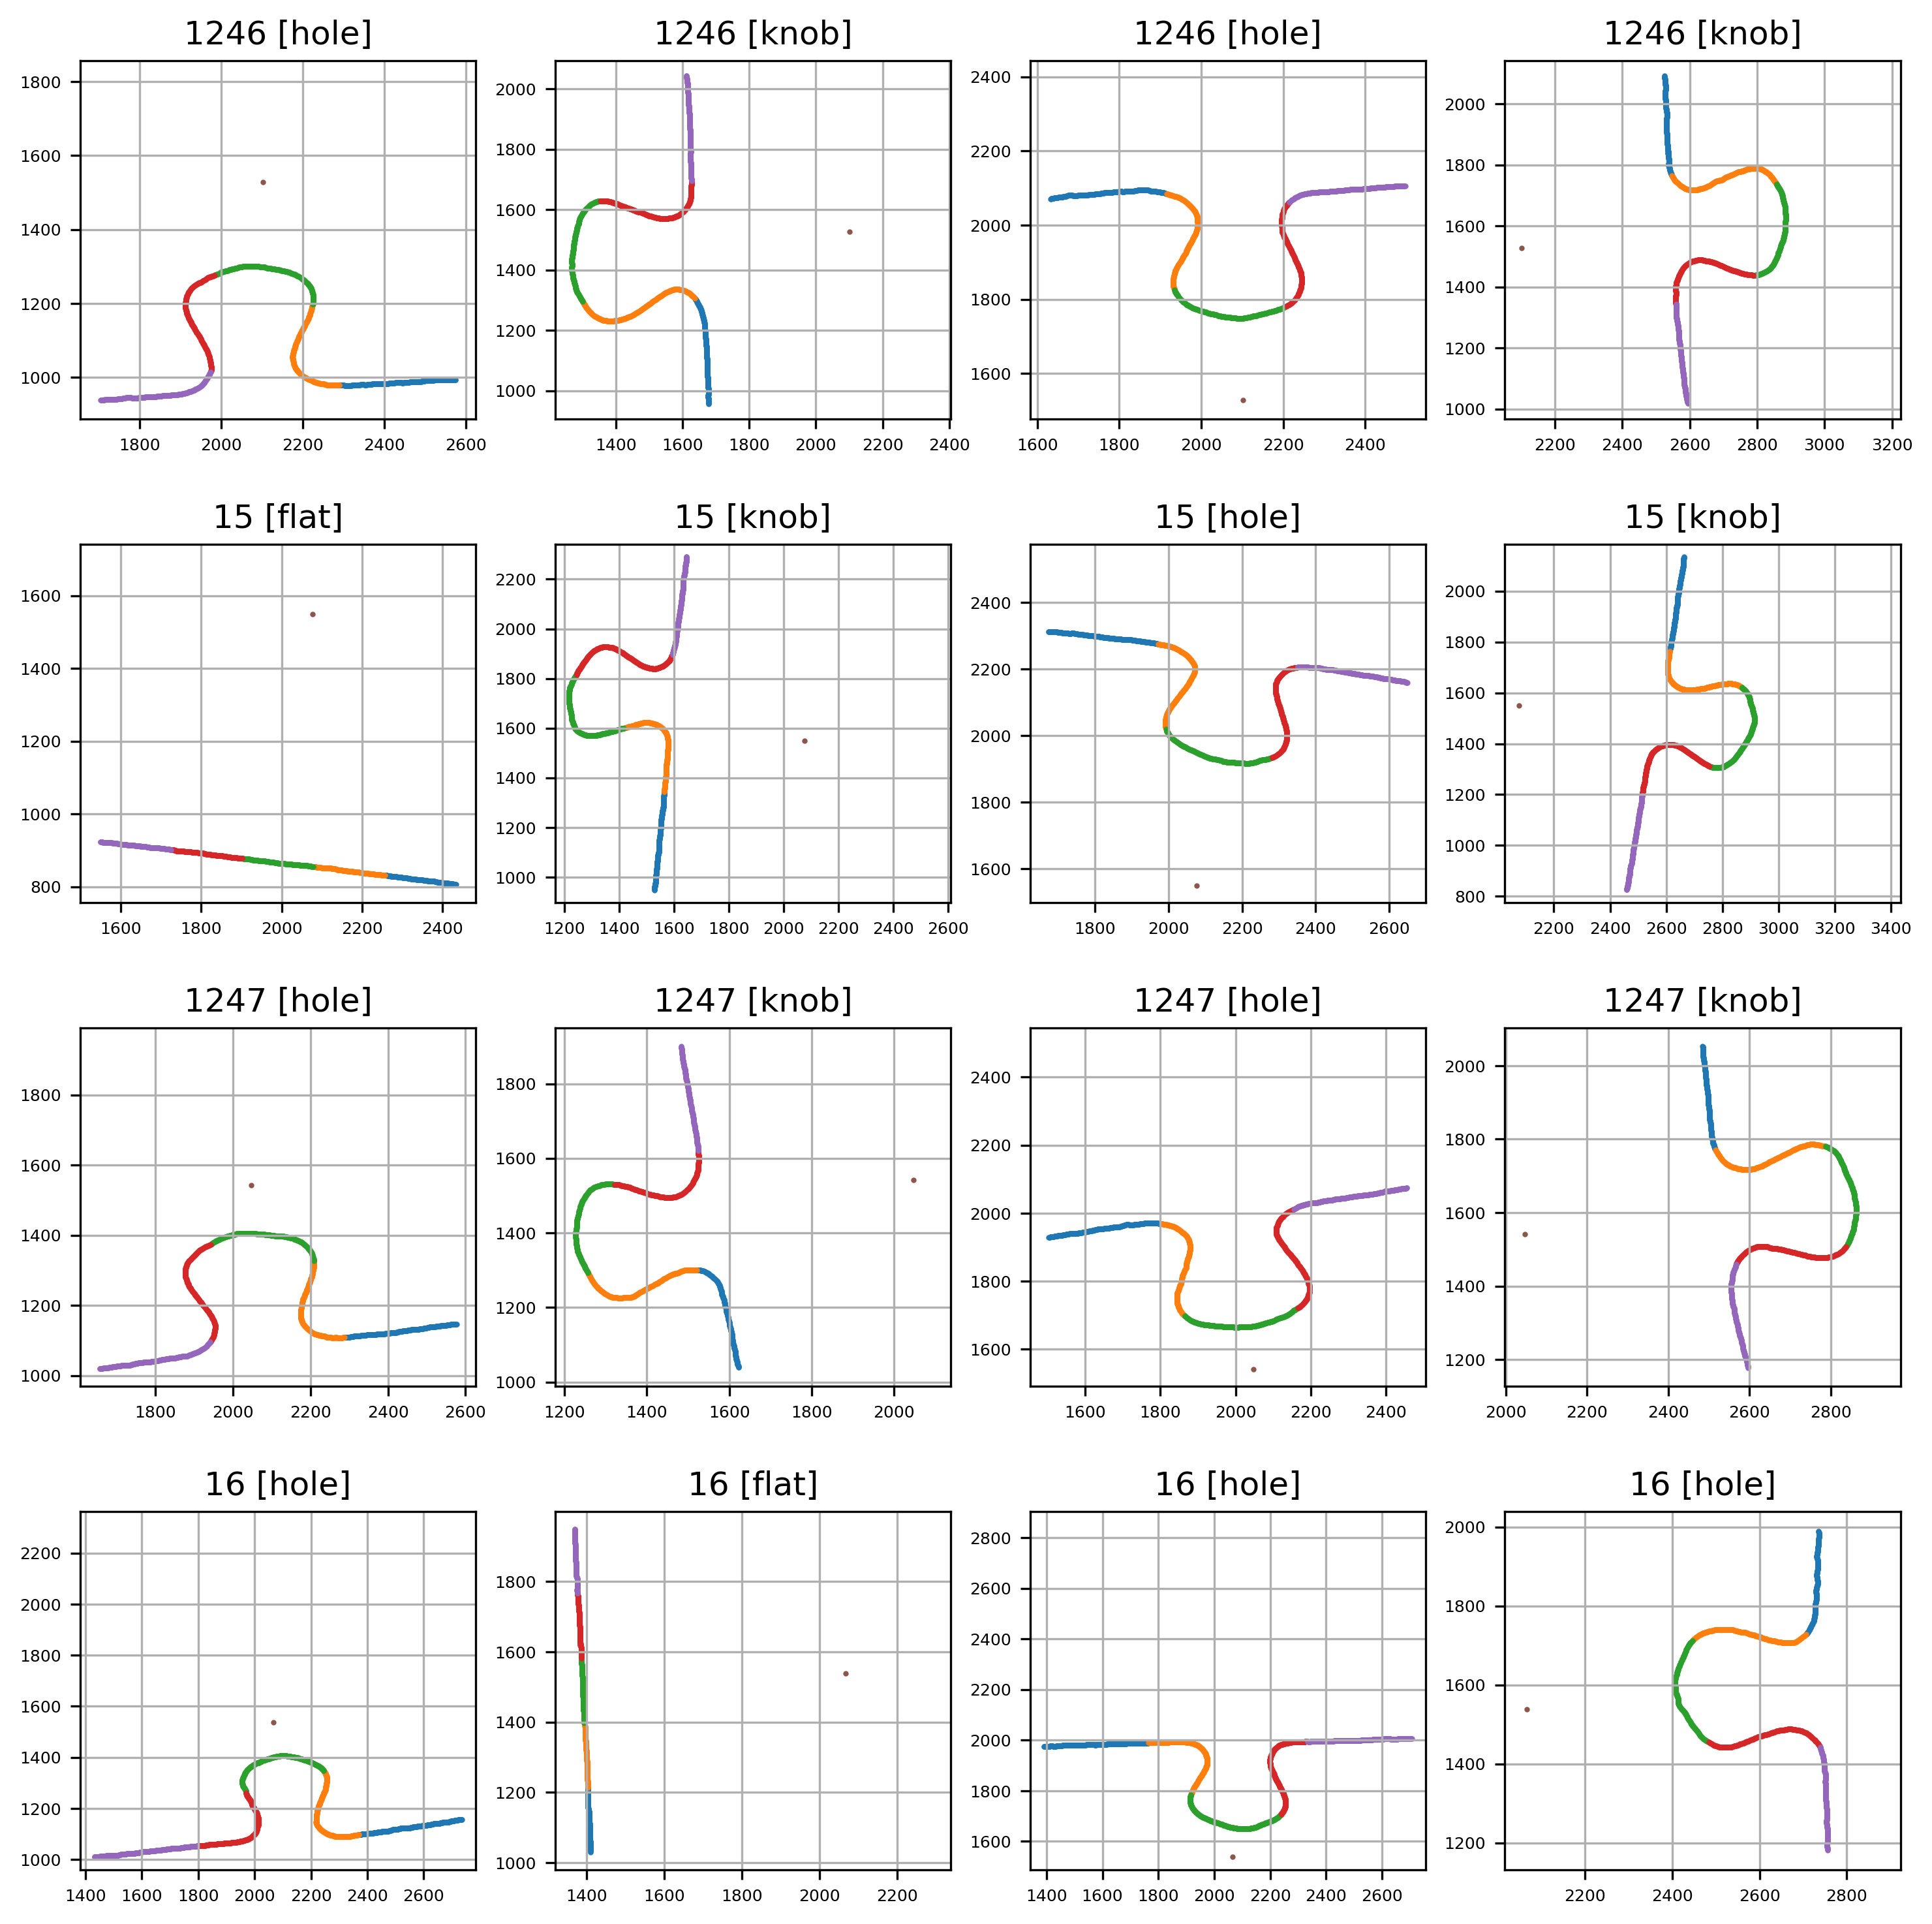

In [8]:
fig, axes = get_figure(len(pieces_ids) * 4)

sides = {}
for piece_idx, piece_id in tqdm(enumerate(pieces_ids)):
    sides[piece_id] = [
        {
            "pixels": side_pixels,
            "corners": side_corners,
            "type": classify_side(
                piece_corners=corners[piece_id],
                side_corners=side_corners,
                side_pixels=side_pixels,
                tolerance=50.0,
            ),
        }
        for side_pixels, side_corners in zip(
            *extract_sides(corners[piece_id], contours[piece_id], corner_margin=20.0)
        )
    ]

    for side_idx, side in enumerate(sides[piece_id]):
        ax = axes[piece_idx * 4 + side_idx]

        title = f"{piece_id} [{side['type']}]"

        steps = 5
        step_size = len(side["pixels"]) // steps

        scatter_plot_lines(
            ax,
            title,
            [side["pixels"][i * step_size : (i + 1) * step_size] for i in range(steps)]
            + [[_get_centroid(corners[piece_id])]],
        )

# Normalize

Rotate and translate sides to roughly the same position in coordinate space. This step simplifies side comparison.

In [9]:
def normalize(side_pixels: PixelList, side_corners: PointList) -> PointList:
    a, b = side_corners

    # Translate points to first corner
    t = [(p[0] - a[0], p[1] - a[1]) for p in side_pixels]

    # Rotate based on side function
    rotation_angle_rad = math.atan2(a[0] - b[0], a[1] - b[1]) + math.pi
    tr = [
        (
            p[0] * math.cos(rotation_angle_rad) - p[1] * math.sin(rotation_angle_rad),
            p[1] * math.cos(rotation_angle_rad) + p[0] * math.sin(rotation_angle_rad),
        )
        for p in t
    ]

    # Translate above x axis
    min_y = min(p[1] for p in tr)
    trt = [(p[0], p[1] - min_y) for p in tr]

    return trt

4it [00:00,  9.86it/s]

[2024-02-17 18:49:14][INFO] Side contents: dict_keys(['pixels', 'corners', 'type', 'points'])


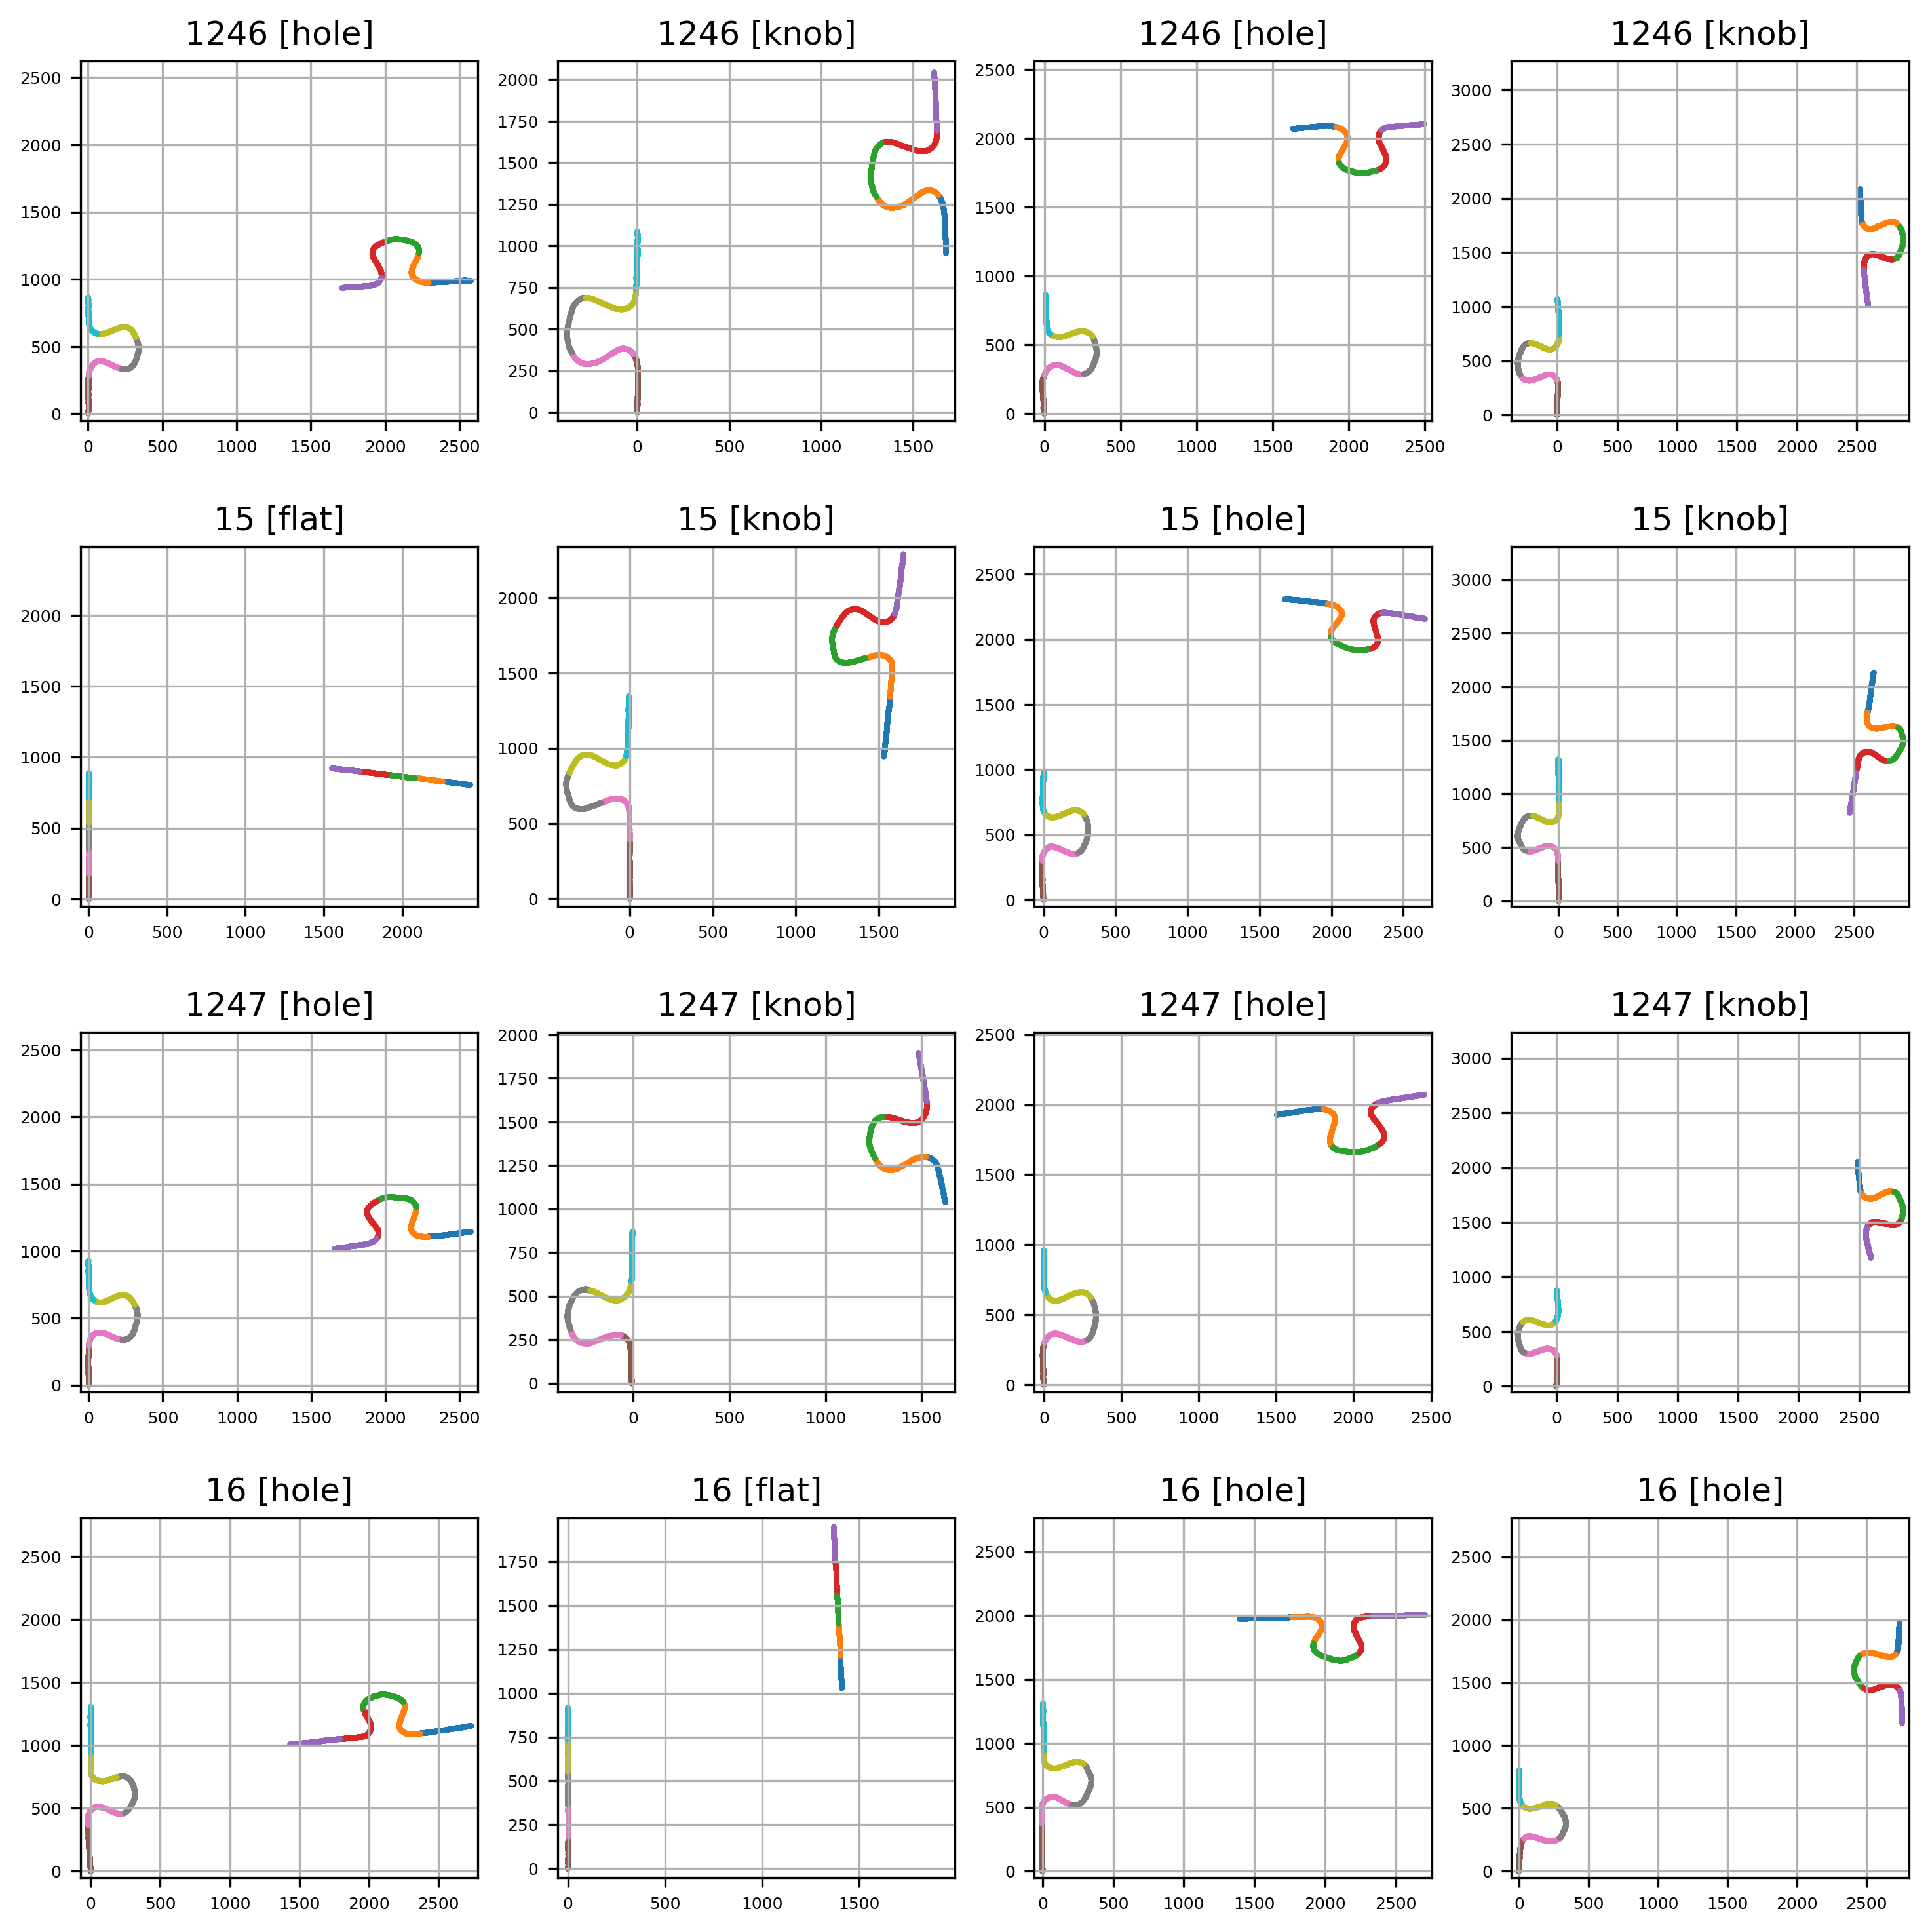

In [10]:
fig, axes = get_figure(len(pieces_ids) * 4)
for piece_idx, piece_id in tqdm(enumerate(pieces_ids)):
    for side_idx, side in enumerate(sides[piece_id]):
        side["points"] = normalize(side["pixels"], side["corners"])

        ax = axes[piece_idx * 4 + side_idx]

        title = f"{piece_id} [{side['type']}]"

        steps = 5
        step_size = len(side["pixels"]) // steps

        scatter_plot_lines(
            ax,
            title,
            [
                *[
                    side["pixels"][i * step_size : (i + 1) * step_size]
                    for i in range(steps)
                ],
                *[
                    side["points"][i * step_size : (i + 1) * step_size]
                    for i in range(steps)
                ],
            ],
        )

log.info(f"Side contents: {side.keys()}")

# Complete dataset

In [11]:
OUT_DIR = os.path.join("data", "out_02")

if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)
os.makedirs(OUT_DIR)

OUT = []
with open(IN_PATH, "rb") as f:
    for piece_id, contour, piece_corners in tqdm(pickle.load(f)):
        contour = tuple(tuple(map(int, pixel)) for pixel in contour)
        piece_corners = tuple(tuple(map(float, point)) for point in piece_corners)

        sides = []
        for side_pixels, side_corners in zip(
            *extract_sides(piece_corners, contour, corner_margin=20.0)
        ):
            side_points = normalize(side_pixels, side_corners)
            side_type = classify_side(
                piece_corners=piece_corners,
                side_corners=side_corners,
                side_pixels=side_pixels,
                tolerance=50.0,
            )

            sides.append({"type": side_type, "points": side_points})

        OUT.append((piece_id, sides))

with open(os.path.join(OUT_DIR, "out.pickle"), "wb") as f:
    pickle.dump(OUT, f)

100%|██████████| 2000/2000 [01:08<00:00, 29.04it/s]


In [12]:
# Sanity checks
cnt_flats = 0
cnt_knobs = 0
cnt_holes = 0
for _, sides in OUT:
    for side in sides:
        match side["type"]:
            case "flat":
                cnt_flats += 1
            case "knob":
                cnt_knobs += 1
            case "hole":
                cnt_holes += 1

cnt_sides = sum(len(sides) for _, sides in OUT)

print(f"{cnt_sides = }")
print(f"{cnt_flats = }")
print(f"{cnt_knobs = }")
print(f"{cnt_holes = }")

cnt_sides = 8000
cnt_flats = 180
cnt_knobs = 3910
cnt_holes = 3910
